In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [3]:
import yfinance as yf

asset = "ES=F"
tk = yf.Ticker(asset)
hist = tk.history(period="max", interval="1mo", auto_adjust=False)[
    ["Close"]
]  # [['Open', 'High', 'Low', 'Close', 'Volume']]
hist.columns = [c.lower() for c in hist.columns]
hist["r_12m"] = hist["close"].pct_change(12)

print(f"{hist.shape = }")
print(hist.head().to_string())

hist.shape = (257, 2)
                            close  r_12m
Date                                    
2000-09-01 00:00:00-04:00  1454.0    NaN
2000-11-01 00:00:00-05:00  1321.0    NaN
2000-12-01 00:00:00-05:00  1327.0    NaN
2001-01-01 00:00:00-05:00  1373.5    NaN
2001-02-01 00:00:00-05:00  1242.0    NaN


In [7]:
tt = pd.read_csv("titanic.csv")
print(f"{tt.shape}")
print(tt.head().to_string())

(891, 15)
   survived  pclass     sex   age  sibsp  parch     fare embarked  class    who  adult_male deck  embark_town alive  alone
0         0       3    male  22.0      1      0   7.2500        S  Third    man        True  NaN  Southampton    no  False
1         1       1  female  38.0      1      0  71.2833        C  First  woman       False    C    Cherbourg   yes  False
2         1       3  female  26.0      0      0   7.9250        S  Third  woman       False  NaN  Southampton   yes   True
3         1       1  female  35.0      1      0  53.1000        S  First  woman       False    C  Southampton   yes  False
4         0       3    male  35.0      0      0   8.0500        S  Third    man        True  NaN  Southampton    no   True


### funcs

In [21]:
def calc_7_numbers(dat: pd.Series) -> list[float]:
    qtls = dat.quantile([0.25, 0.5, 0.75]).to_list()
    icr_1_point_5 = (qtls[2] - qtls[0]) * 1.5
    fivnum = [
        dat.min(),
        max(qtls[0] - icr_1_point_5, dat.min()),
        qtls[0],
        qtls[1],
        qtls[2],
        min(qtls[2] + icr_1_point_5, dat.max()),
        dat.max(),
    ]
    return fivnum


In [36]:
def even_width_bins(dat: pd.Series, nbins: int) -> list[float]:
    return np.arange(dat.min(), dat.max() + (dat.max() - dat.min()) / nbins, (dat.max() - dat.min()) / nbins)


In [132]:
def bin_cat_to_pct_labels(cats: pd.Index) -> list[str]:
    """cat is [)"""
    labels = []
    for category in cats:
        if pd.isna(category):
            labels.append("NaN")
        else:
            left = category.left
            right = category.right
            mid = (left + right) / 2
            labels.append(f"[{left:.0%} - {right:.0%})")
    return labels

def bin_cat_to_mid_labels(cats: pd.Index) -> list[str]:
    labels = []
    for category in cats:
        if pd.isna(category):
            labels.append("NaN")
        else:
            left = category.left
            right = category.right
            mid = (left + right) / 2
            labels.append(f"~{mid:.0%}")
    return labels

In [134]:
def calc_freq_signal(sdf:pd.DataFrame, col) -> pd.DataFrame:
    sdf = (
        sdf
        .loc[lambda x: x[col].notna(), :]
        .groupby([col], dropna=False, observed=False).agg(
            **{
                "n": (col, "size"),
            }
        )
    )
    sdf[f"{col}_freq"] = sdf["n"] / sdf["n"].sum()
    return sdf



In [152]:

def plot_pct_interval_histogram(x_ticks, x_labels, y, ax=None) -> tuple:

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    else:
        fig = ax.get_figure()

    ax.bar(
        x_ticks,
        y,
        width=0.8,
        alpha=0.7,
        color="lightblue",
        edgecolor="black",
    )
    for x, yv in zip(x_ticks, y):
        ax.text(x, yv, f"{yv:.1%}", ha="center", va="bottom")
    ax.set_xticks(x_ticks, x_labels, rotation=45, ha="right")

    ax.grid(True, linestyle="--", alpha=0.5)

    return fig, ax

In [153]:
def pct_histogram_from_edges(dat:pd.DataFrame, col:str, edges:list, ax:None) -> tuple:

    hist[f"{col}_binned"] = pd.cut(hist[col], bins=edges, right=False)
    freqs = calc_freq_signal(hist, col = f"{col}_binned")
    fig, ax = plot_pct_interval_histogram(
        x_ticks = np.arange(freqs.shape[0], dtype=int), 
        x_labels = bin_cat_to_pct_labels(freqs.index), 
        y = freqs[f"{col}_binned_freq"],
        ax = ax,
    )

### 5 numbers / box plot

In [22]:
dat = hist["r_12m"].dropna()
fivnum = calc_7_numbers(dat)
fivnum

[np.float64(-0.44322220341851415),
 -0.25436611381110075,
 0.025267470976553685,
 0.11741214057507987,
 0.21168986083498997,
 np.float64(0.4575388620874492),
 np.float64(0.4575388620874492)]

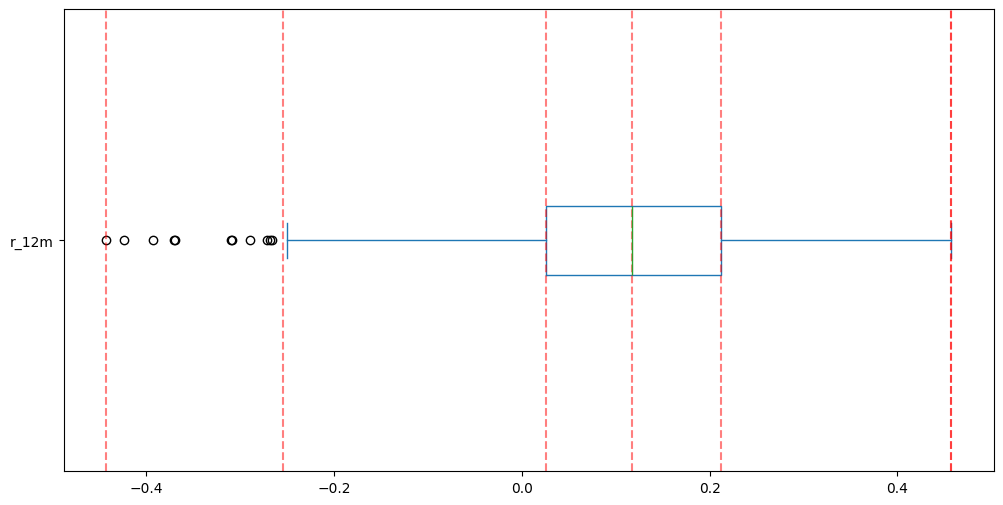

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
dat.plot(kind='box', vert=False, ax=ax)
for n in fivnum:
    ax.axvline(n, color='red', linestyle='--', alpha=0.5)

### histgram with fixed width bars

In [168]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# even width
pct_histogram_from_edges(
    dat = hist["r_12m"].dropna(),
    col = "r_12m",
    edges = np.histogram_bin_edges(hist["r_12m"].dropna(), bins=10),
    ax = axs[0][0]
)

# even width 2
pct_histogram_from_edges(
    dat = hist["r_12m"].dropna(),
    col = "r_12m",
    edges = np.linspace(-0.5, 0.5, 11),
    ax = axs[0][1]
)

# by proportion
pct_histogram_from_edges(
    dat = hist["r_12m"].dropna(),
    col = "r_12m",
    edges = hist["r_12m"].dropna().quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).to_list(),
    ax = axs[1][0]
)

# defined
pct_histogram_from_edges(
    dat = hist["r_12m"].dropna(),
    col = "r_12m",
    edges = [-np.inf, -0.0, 0.05, 0.15, np.inf],
    ax = axs[1][1]
)

plt.tight_layout()
plt.close("all")

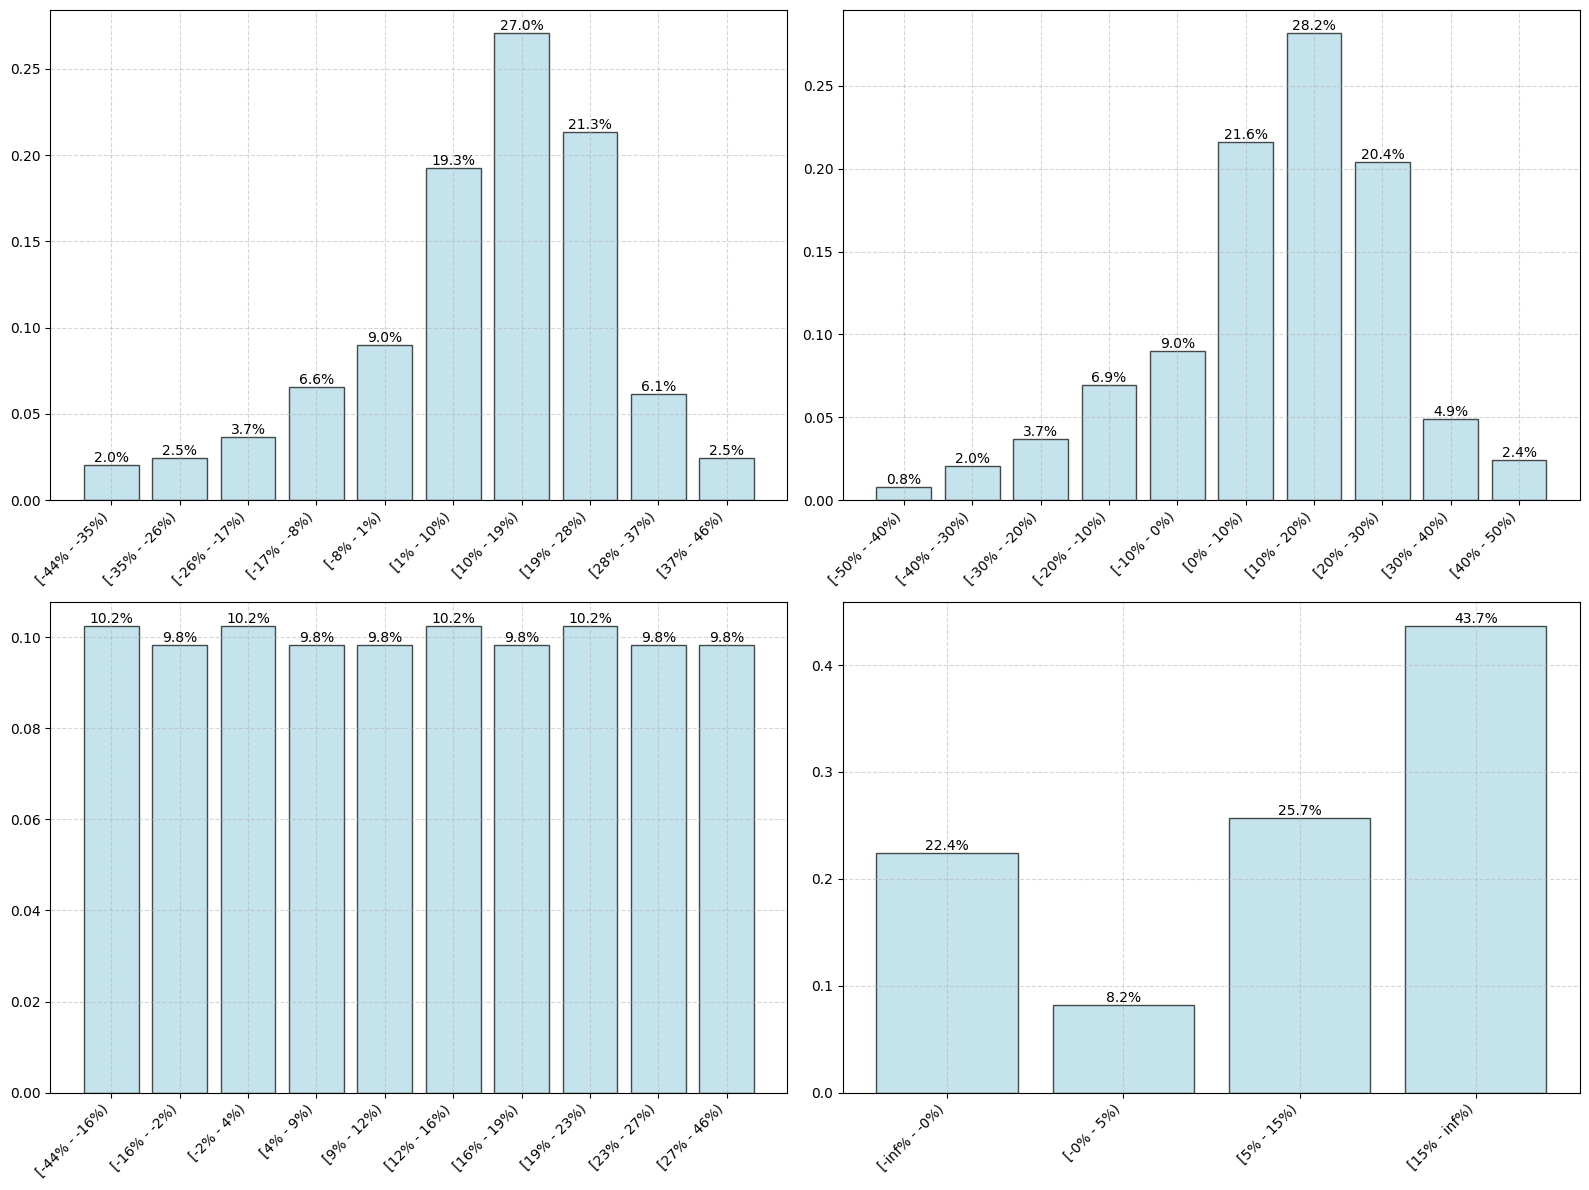

In [169]:
fig